Prepare the TFLite model

Time to shift gears to TensorFlow 2.x (2.2.0 or any higher nightly versions). In this section, we will be using the SavedModel we generated previously and convert it to a TFLite flat buffer, which is about 10 MB in size and perfectly usable in a Mobile Application. Then we will use a few of the latest TensorFlow Lite tools to prepare the model for deployment:
- Run inference in Python with the TFLite model to make sure it’s good after the conversion.
- Add metadata to the TFLite model to make integrating it to an Android app easier with the Android Studio’s ML Model Binding plugin.
- Use the Benchmark tool to see how the model would perform on mobile devices.

## TF Lite conversion

In [ ]:
%pip install -q tensorflow==2.2.0
%pip install matplotlib

In [2]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
def convert_to_tflite(saved_model_path, tflite_model_path):
    # First, we load the SavedModel files and create a concrete function from them
    model = tf.saved_model.load(saved_model_path)
    concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]
    
    # The advantage of doing the conversion in this way is it gives us the flexibility to set 
    # the shapes of the input and output tensors of the resulting TFLite model. 
    # You can see this in the following code snippet
    concrete_func.inputs[0].set_shape([1, 256, 256, 3])
    concrete_func.outputs[0].set_shape([1, 256, 256, 3])
    # It is recommended to use the original shapes of the input and output tensors that were used 
    # during training the model accordingly. In this case, this shape is (1, 256, 256, 3) 
    # and 1 denotes the batch dimension. This is required because the model expects the data to be in 
    # the shape of: BATCH_SIZE, IMAGE_SHAPE, IMAGE_SHAPE, NB_CHANNELS.
    
    # To do the actual conversion we run the following
    converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
    converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    tflite_model = converter.convert()

    with tf.io.gfile.GFile(tflite_model_path, 'wb') as f:
        f.write(tflite_model)
    print('Fixed-point Quantized model:', tflite_model_path, 
        'Size:', len(tflite_model) / 1024, "kb")

In [4]:
convert_to_tflite('./saved_model/', 'selfie2anime.tflite') 

Fixed-point Quantized model: selfie2anime.tflite Size: 10488.6875 kb


## Running inference with the TF Lite model

### Gather an example image

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
def load_image(path):
  image_raw = tf.io.read_file(path)
  image = tf.image.decode_image(image_raw, channels=3)
  return image

(300, 300, 3)


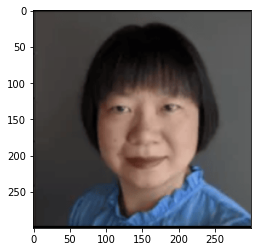

In [17]:
test_image_original = load_image("./test300x300.png")
print(test_image_original.shape)
plt.imshow(test_image_original)
plt.show()

### Preprocess the image

In [18]:
def resize(image):
    resized_image =  tf.image.resize(image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_image = tf.cast(resized_image, tf.float32)
    resized_image = tf.expand_dims(resized_image, 0)

    return resized_image

In [19]:
test_image_resized = resize(test_image_original)
test_image_resized.shape

TensorShape([1, 256, 256, 3])

### Run inference on the preprocessed image

In [20]:
with tf.io.gfile.GFile('selfie2anime.tflite', 'rb') as f:
    model_content = f.read()

# Initialze TensorFlow Lite inpterpreter.
interpreter = tf.lite.Interpreter(model_content=model_content)
interpreter.allocate_tensors()
input_index = interpreter.get_input_details()[0]['index']
output = interpreter.tensor(interpreter.get_output_details()[0]["index"])

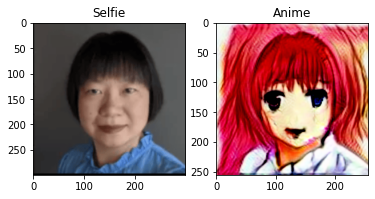

In [21]:
# Set model input
interpreter.set_tensor(input_index, test_image_resized)

# Run inference
interpreter.invoke()

# Visualize results
plt.subplot(121)
plt.title('Selfie')
plt.imshow(test_image_original)

plt.subplot(122)
plt.title('Anime')
plt.imshow(output()[0])